# 데이터 전처리 - 아스카로바

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# 데이터 폴더 경로
from google.colab import drive
drive.mount('/content/drive')

data_folder = '/content/drive/MyDrive/3months_data'  # Update with the correct path


Mounted at /content/drive


In [ ]:
all_files = os.listdir(data_folder)
csv_files = [os.path.join(data_folder, f) for f in all_files if f.endswith('.csv')]


#가능한 모든 인코딩
def read_csv_file(file_path):
    encodings = ['utf-8', 'cp949', 'euc-kr']  # List of possible encodings
    for encoding in encodings:
        try:
            return pd.read_csv(file_path, encoding=encoding)
        except (UnicodeDecodeError, pd.errors.EmptyDataError, pd.errors.ParserError):
            continue
    raise ValueError(f"Could not read file {file_path} with any encoding.")


valid_dataframes = []
#모든 파일을 포함한 dataframe 만들기
for file in csv_files:
    try:
        df = read_csv_file(file)
        if not df.empty:  # Check if the DataFrame has data
            #print(f"File '{file}' read successfully with {len(df)} rows.")
            valid_dataframes.append(df)
        else:
            print(f"File '{file}' is empty and will be skipped.")
    except ValueError as e:
        print(e)
#empty 파일 제외한 모든 파일을 dataframe으로 추가하기

# Combine only the valid DataFrames
if valid_dataframes:
    combined_data = pd.concat(valid_dataframes, ignore_index=True)
else:
    combined_data = pd.DataFrame()  # Empty DataFrame if no valid files found

# Verify the combined DataFrame
#print(f"Total rows in combined data: {len(combined_data)}")
#print(combined_data.head())



File '/content/drive/MyDrive/3months_data/28_2024-07-25.csv' is empty and will be skipped.
File '/content/drive/MyDrive/3months_data/28_2024-07-26.csv' is empty and will be skipped.
File '/content/drive/MyDrive/3months_data/28_2024-07-27.csv' is empty and will be skipped.
File '/content/drive/MyDrive/3months_data/28_2024-07-28.csv' is empty and will be skipped.
File '/content/drive/MyDrive/3months_data/28_2024-07-29.csv' is empty and will be skipped.
File '/content/drive/MyDrive/3months_data/28_2024-07-30.csv' is empty and will be skipped.
File '/content/drive/MyDrive/3months_data/28_2024-07-31.csv' is empty and will be skipped.
File '/content/drive/MyDrive/3months_data/28_2024-08-01.csv' is empty and will be skipped.
File '/content/drive/MyDrive/3months_data/28_2024-08-02.csv' is empty and will be skipped.
File '/content/drive/MyDrive/3months_data/28_2024-08-06.csv' is empty and will be skipped.
File '/content/drive/MyDrive/3months_data/28_2024-08-07.csv' is empty and will be skipped.

In [ ]:
combined_data.columns = [
    "생성일", "부하율", "설정 압력",
    "보일러 압력", "송풍기 인버터 출력", "송풍기 입력",
    "급수 펌프", "급수펌프 입력", "가스 댐퍼",
    "가스 댐퍼 입력", "Air 댐퍼", "Air 댐퍼 입력",
    "재순환 댐퍼", "재순환 외기 댐퍼", "재순환 댐퍼 입력",
    "재순환 외기 댐퍼 입력", "급수 수위", "보일러 온도",
    "배기가스온도1", "배기가스온도2", "배기가스온도3",
    "배기 재 순환 온도", "에코 온도1", "에코 온도2",
    "버너온도", "배기가스 NOx", "배기가스 O2",
    "재순환 O2", "재순환 NOx", "급수량(적산유량)",
    "급수량(순간유량)", "연료량(적산유량)", "연료량(순간유량)",
    "효율(순간)", "소비전류", "진동센서1",
    "진동센서2", "운전시간", "정상 운전 확률",
    "송풍기 고장 확률", "AIR 댐퍼 고장 확률", "GAS 앰퍼 고장 확률",
    "확률 업데이트 시간", "순간 스팀량", "입출력법 효율",
    "열 손실법 효율", "효율(입출력법-스팀)"
]


combined_data = combined_data.drop(columns=[
    "생성일",
    "소비전류",
    "진동센서1",
    "진동센서2",
    "운전시간",
    "정상 운전 확률",
    "송풍기 고장 확률",
    "AIR 댐퍼 고장 확률",
    "GAS 앰퍼 고장 확률",
    "확률 업데이트 시간",
    "순간 스팀량",
    "입출력법 효율",
    "열 손실법 효율",
    "효율(입출력법-스팀)",
    "배기 재 순환 온도",
    "버너온도"
])


#combined_data.fillna(method='ffill', inplace=True)  # Forward fill missing values
#combined_data.fillna(method='bfill', inplace=True)  # Backward fill for any remaining NaNs

scaler = StandardScaler()
numeric_columns = combined_data.select_dtypes(include=['float64', 'int64']).columns
combined_data[numeric_columns] = scaler.fit_transform(combined_data[numeric_columns])

# Select numerical columns only
numerical_columns = combined_data.select_dtypes(include=['float64', 'int64']).columns

# Fill missing values in numerical columns with the mean value
combined_data[numerical_columns] = combined_data[numerical_columns].apply(lambda col: col.fillna(col.mean()))

# For categorical columns, fill missing values with the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
combined_data[combined_data.select_dtypes(include=['object']).columns] = cat_imputer.fit_transform(combined_data.select_dtypes(include=['object']))

# Encode categorical variables (if any)
label_encoder = LabelEncoder()
for column in combined_data.select_dtypes(include=['object']).columns:
    combined_data[column] = label_encoder.fit_transform(combined_data[column])




In [ ]:
combined_data.to_csv('/content/drive/MyDrive/preprocessed_boiler_data.csv', index=False, encoding='utf-8')


# XGBoost (RF 알고리즘으로 하이퍼 파라미터 튜닝) - 주열

## 모델

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 타겟 변수와 특징 변수 분리
X = df.drop(columns=['효율(순간)'])  # 타겟 변수를 제외한 특징 변수
y = df['효율(순간)']  # 타겟 변수

# 범주형 변수를 One-Hot Encoding으로 변환
X_encoded = pd.get_dummies(X)

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.3 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# XGBoost 모델 초기화
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# 하이퍼파라미터 범위 설정
param_dist = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(3, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1)
}

# 랜덤 서치 설정
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # 시도할 조합의 수
    scoring='neg_mean_squared_error',
    cv=5,  # 5겹 교차검증
    verbose=1,
    random_state=42,
    n_jobs=-1  # 모든 CPU 코어 사용
)

# 랜덤 서치 실행
random_search.fit(X_train, y_train)

# 최적의 파라미터 출력
print("최적의 하이퍼파라미터:", random_search.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


최적의 하이퍼파라미터: {'subsample': 0.8999999999999999, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.2, 'colsample_bytree': 0.5}


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np  # numpy를 임포트하여 sqrt 사용

# 예측
y_pred = random_search.predict(X_test)

# 성능 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # RMSE 계산

# MAPE 계산
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE 계산 (백분율로)

# 결과 출력
print(f'테스트 데이터 MSE: {mse}')
print(f'테스트 데이터 MAE: {mae}')
print(f'테스트 데이터 RMSE: {rmse}')
print(f'테스트 데이터 MAPE: {mape:.2f}%')  # MAPE를 소수점 2자리로 포맷


테스트 데이터 MSE: 0.20851213871603325
테스트 데이터 MAE: 0.10359154530361854
테스트 데이터 RMSE: 0.4566312940612297
테스트 데이터 MAPE: 6.04%


## 데이터 시각화 - 영어

<ipython-input-9-863e2e696190>:85: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from current font.
  plt.tight_layout()
<ipython-input-9-863e2e696190>:85: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  plt.tight_layout()
<ipython-input-9-863e2e696190>:85: UserWarning: Glyph 49468 (\N{HANGUL SYLLABLE SEN}) missing from current font.
  plt.tight_layout()
<ipython-input-9-863e2e696190>:85: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  plt.tight_layout()
<ipython-input-9-863e2e696190>:85: UserWarning: Glyph 50544 (\N{HANGUL SYLLABLE AEM}) missing from current font.
  plt.tight_layout()
<ipython-input-9-863e2e696190>:85: UserWarning: Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from current font.
  plt.tight_layout()
<ipython-input-9-863e2e696190>:85: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  plt.tight_layout()
<ipython-input-9-863e2e696190>:85: UserWarning: Glyph 51109 (\

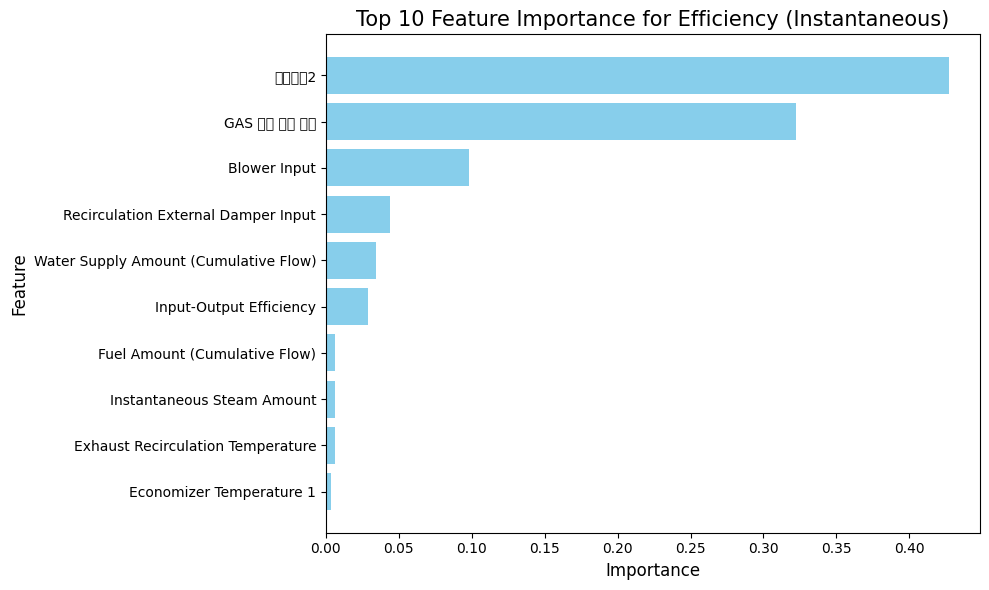

                                  Feature  Importance
45                                  진동센서2    0.427137
19                           GAS 앰퍼 고장 확률    0.322407
4                            Blower Input    0.097987
33    Recirculation External Damper Input    0.043942
38  Water Supply Amount (Cumulative Flow)    0.034509
23                Input-Output Efficiency    0.029067
17          Fuel Amount (Cumulative Flow)    0.006304
24             Instantaneous Steam Amount    0.006216
16      Exhaust Recirculation Temperature    0.005948
10               Economizer Temperature 1    0.003556


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import re

# XGBoost 모델에서 특성 중요도 가져오기
feature_importances = random_search.best_estimator_.feature_importances_

# 특성 이름과 중요도를 DataFrame으로 변환
importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': feature_importances
})

# 특성 이름을 한글에서 영어로 변경
feature_mapping = {
    "생성일": "Creation date",
    "부하율": "Load factor",
    "설정 압력": "Set Pressure",
    "보일러 압력": "Boiler Pressure",
    "송풍기 인버터 출력": "Blower Inverter Output",
    "송풍기 입력": "Blower Input",
    "급수 펌프": "Water Supply Pump",
    "급수펌프 입력": "Water Supply Pump Input",
    "가스 댐퍼": "Gas Damper",
    "가스 댐퍼 입력": "Gas Damper Input",
    "Air 댐퍼": "Air Damper",
    "Air 댐퍼 입력": "Air Damper Input",
    "재순환 댐퍼": "Recirculation Damper",
    "재순환 외기 댐퍼": "Recirculation External Damper",
    "재순환 댐퍼 입력": "Recirculation Damper Input",
    "재순환 외기 댐퍼 입력": "Recirculation External Damper Input",
    "급수 수위": "Water Supply Level",
    "보일러 온도": "Boiler Temperature",
    "배기가스온도1": "Exhaust Gas Temperature 1",
    "배기가스온도2": "Exhaust Gas Temperature 2",
    "배기가스온도3": "Exhaust Gas Temperature 3",
    "배기 재 순환 온도": "Exhaust Recirculation Temperature",
    "에코 온도1": "Economizer Temperature 1",
    "에코 온도2": "Economizer Temperature 2",
    "버너온도": "Burner Temperature",
    "배기가스 NOx": "Exhaust Gas NOx",
    "배기가스 O2": "Exhaust Gas O2",
    "재순환 O2": "Recirculation O2",
    "재순환 NOx": "Recirculation NOx",
    "급수량(적산유량)": "Water Supply Amount (Cumulative Flow)",
    "급수량(순간유량)": "Water Supply Amount (Instantaneous Flow)",
    "연료량(적산유량)": "Fuel Amount (Cumulative Flow)",
    "연료량(순간유량)": "Fuel Amount (Instantaneous Flow)",
    "효율(순간)": "Efficiency (Instantaneous)",
    "소비전류": "Power Consumption",
    "진동센서1": "Vibration Sensor 1",
    "진동센서2": "Vibration Sensor 2",
    "운전시간": "Operating Time",
    "정상 운전 확률": "Normal Operation Probability",
    "송풍기 고장 확률": "Blower Failure Probability",
    "AIR 댐퍼 고장 확률": "Air Damper Failure Probability",
    "GAS 앰퍼 고장 확률": "Gas Damper Failure Probability",
    "확률 업데이트 시간": "Probability Update Time",
    "순간 스팀량": "Instantaneous Steam Amount",
    "입출력법 효율": "Input-Output Efficiency",
    "열 손실법 효율": "Heat Loss Efficiency",
    "효율(입출력법-스팀)": "Efficiency (input/output method-steam)"
}

# 특성 이름 변경
importance_df['Feature'] = importance_df['Feature'].replace(feature_mapping)

# 특성 이름에서 날짜나 시간 정보 등 불필요한 부분 제거
importance_df['Feature'] = importance_df['Feature'].apply(lambda x: re.sub(r'(_\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})|(_\d+:\d+)', '', x))

# 동일한 특성 이름들의 중요도를 합산
importance_df = importance_df.groupby('Feature', as_index=False).sum()

# 상위 N개의 중요도만 필터링
top_n = 10
top_features = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # 중요도가 높은 순서부터 표시
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 10 Feature Importance for Efficiency (Instantaneous)', fontsize=15)
plt.tight_layout()
plt.show()

# 출력할 때 특성 이름과 중요도만 포함하여 확인
print(top_features[['Feature', 'Importance']])


## 데이터 시각화 - 한글

In [ ]:
# !apt-get install -y fonts-nanum
# !fc-cache -fv
# !rm ~/.cache/matplotlib -rf
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
# !ls /usr/share/fonts/truetype/nanum/


NanumBarunGothicBold.ttf  NanumGothicCodingBold.ttf  NanumMyeongjoBold.ttf  NanumSquareRoundB.ttf
NanumBarunGothic.ttf	  NanumGothicCoding.ttf      NanumMyeongjo.ttf	    NanumSquareRoundR.ttf
NanumGothicBold.ttf	  NanumGothic.ttf	     NanumSquareB.ttf	    NanumSquareR.ttf


In [ ]:
# !fc-list :lang=ko


/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Bold,나눔스퀘어라운드 Bold:style=Bold,Regular
/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf: NanumGothicCoding,나눔고딕코딩:style=Bold
/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Regular,나눔스퀘어라운드 Regular:style=Regular
/usr/share/fonts/truetype/nanum/NanumSquareB.ttf: NanumSquare,나눔스퀘어,NanumSquare Bold,나눔스퀘어 Bold:style=Bold
/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf: NanumBarunGothic,나눔바른고딕:style=Regular
/usr/share/fonts/truetype/nanum/NanumGothic.ttf: NanumGothic,나눔고딕:style=Regular
/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf: NanumGothicCoding,나눔고딕코딩:style=Regular
/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf: NanumBarunGothic,나눔바른고딕:style=Bold
/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf: NanumGothic,나눔고딕:style=Bold
/usr/share/fonts/truetype/nanum/NanumSquareR.ttf: NanumSquare,나눔스퀘어:style=Regular
/us

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


<ipython-input-22-f22dce164a5c>:34: UserWarning: Glyph 49569 (\N{HANGUL SYLLABLE SONG}) missing from current font.
  plt.tight_layout()
<ipython-input-22-f22dce164a5c>:34: UserWarning: Glyph 54413 (\N{HANGUL SYLLABLE PUNG}) missing from current font.
  plt.tight_layout()
<ipython-input-22-f22dce164a5c>:34: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
<ipython-input-22-f22dce164a5c>:34: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from current font.
  plt.tight_layout()
<ipython-input-22-f22dce164a5c>:34: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  plt.tight_layout()
<ipython-input-22-f22dce164a5c>:34: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from current font.
  plt.tight_layout()
<ipython-input-22-f22dce164a5c>:34: UserWarning: Glyph 49692 (\N{HANGUL SYLLABLE SUN}) missing from current font.
  plt.tight_layout()
<ipython-input-22-f22dce164a5c>:34: UserWarning: Glyp

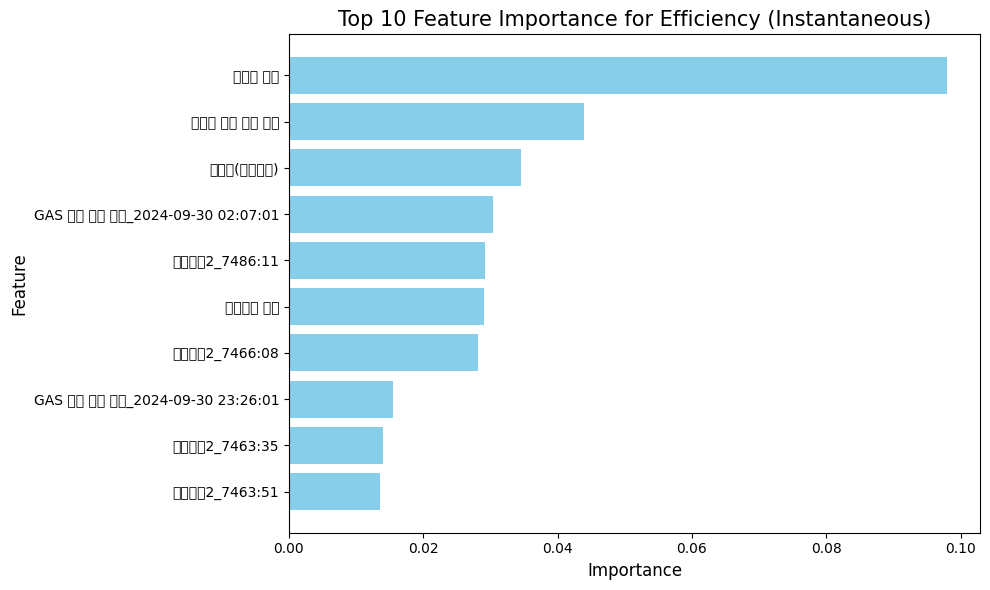

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd

# Google Colab에 NanumGothic 폰트 설치
!apt-get -y install fonts-nanum

# 폰트 설정
plt.rc('font', family='NanumBarunGothic')  # NanumGothic 사용

# 한글 깨짐 방지 및 음수 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# XGBoost 모델에서 특성 중요도 가져오기
feature_importances = random_search.best_estimator_.feature_importances_

# 특성 이름과 중요도를 DataFrame으로 변환
importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 상위 10개의 중요도만 시각화
top_n = 10
top_features = importance_df.head(top_n)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # 중요도가 높은 순서부터 표시
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 10 Feature Importance for Efficiency (Instantaneous)', fontsize=15)
plt.tight_layout()
plt.show()


# XGBoost (RF 알고리즘으로 하이퍼 파라미터 튜닝) -희성

In [ ]:
import pandas as pd  # 데이터 처리에 사용되는 pandas 라이브러리 임포트
import numpy as np  # 수치 계산을 위한 numpy 라이브러리 임포트
from sklearn.model_selection import train_test_split, RandomizedSearchCV  # 데이터 분리 및 하이퍼파라미터 튜닝을 위한 모듈 임포트
import xgboost as xgb  # XGBoost 모델을 사용하기 위한 라이브러리 임포트
from sklearn.metrics import mean_squared_error, mean_absolute_error  # 회귀 모델 평가를 위한 메트릭 임포트
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 matplotlib 임포트
import seaborn as sns  # 데이터 시각화를 위한 seaborn 임포트

# 데이터 불러오기
combined_data = pd.read_csv('/content/drive/MyDrive/preprocessed_boiler_data.csv')  # 전처리된 CSV 파일을 읽어와 DataFrame으로 저장

# 특성과 타겟 변수 분리
X = combined_data.drop(columns=['효율(순간)'])  # 타겟 변수를 제외한 특징 변수로 X 설정
y = combined_data['효율(순간)']  # 타겟 변수로 '효율(순간)' 열 설정

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 데이터를 80% 훈련 세트, 20% 테스트 세트로 분리

# XGBoost 모델 초기화
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')  # 회귀 모델을 위한 XGBoost 초기화

# 하이퍼파라미터 범위 설정
param_dist = {  # 하이퍼파라미터 범위 정의
    'n_estimators': np.arange(50, 500, 50),  # 트리의 개수
    'max_depth': np.arange(3, 10),  # 트리의 최대 깊이
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # 학습률
    'subsample': np.arange(0.5, 1.0, 0.1),  # 각 트리가 학습할 데이터 비율
    'colsample_bytree': np.arange(0.5, 1.0, 0.1)  # 각 트리가 사용할 피처 비율
}

# 랜덤 서치 설정
random_search = RandomizedSearchCV(  # 랜덤 서치 객체 생성
    xgb_model,  # 사용할 모델
    param_distributions=param_dist,  # 하이퍼파라미터 범위
    n_iter=100,  # 시도할 조합의 수
    scoring='neg_mean_squared_error',  # 평가 지표로 음의 평균 제곱 오차 사용
    cv=5,  # 5겹 교차 검증
    verbose=1,  # 진행 상황 출력
    random_state=42,  # 난수 시드 설정
    n_jobs=-1  # 모든 CPU 코어 사용
)

# 랜덤 서치 실행
random_search.fit(X_train, y_train)  # 훈련 데이터를 사용하여 랜덤 서치 실행

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", random_search.best_params_)  # 찾은 최적의 하이퍼파라미터 출력

# 예측
y_pred = random_search.predict(X_test)  # 테스트 데이터를 사용하여 예측 수행

# 성능 평가
mse = mean_squared_error(y_test, y_pred)  # 평균 제곱 오차 계산
mae = mean_absolute_error(y_test, y_pred)  # 평균 절대 오차 계산
rmse = np.sqrt(mse)  # 제곱근 평균 제곱 오차 계산

# MAPE 계산
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # 평균 절대 비율 오차 계산 (백분율로)

# 결과 출력
print(f'테스트 데이터 MSE: {mse}')  # 테스트 데이터의 MSE 출력
print(f'테스트 데이터 MAE: {mae}')  # 테스트 데이터의 MAE 출력
print(f'테스트 데이터 RMSE: {rmse}')  # 테스트 데이터의 RMSE 출력
print(f'테스트 데이터 MAPE: {mape:.2f}%')  # 테스트 데이터의 MAPE 출력 (소수점 2자리로 포맷)

# 상관 행렬 시각화
plt.figure(figsize=(12, 8))  # 그림 크기 설정
correlation_matrix = combined_data.corr()  # 상관 행렬 계산
sns.heatmap(correlation_matrix[['효율(순간)']].sort_values(by='효율(순간)', ascending=False),  # '효율(순간)'과의 상관 관계 시각화
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)  # 각 셀에 값 표시, 색상 맵 설정
plt.title('Correlation with Efficiency (Instantaneous)')  # 제목 설정
plt.show()  # 그래프 출력


Fitting 5 folds for each of 100 candidates, totalling 500 fits


ValueError: 
All the 500 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1081, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 596, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1003, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1573, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1632, in _init
    it.reraise()
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 569, in reraise
    raise exc  # pylint: disable=raising-bad-type
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 550, in _handle_exception
    return fn()
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 637, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 1416, in next
    input_data(**self.kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 617, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 1459, in _proxy_transform
    df, feature_names, feature_types = _transform_pandas_df(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 603, in _transform_pandas_df
    pandas_check_dtypes(data, enable_categorical)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 569, in pandas_check_dtypes
    _invalid_dataframe_dtype(data)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 356, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:배기가스온도3: object, 에코 온도2: object
